<a href="https://colab.research.google.com/github/Kwannn666/DL_Report2/blob/main/DL_Report2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import random
import json
from pathlib import Path
from tqdm import tqdm
import urllib.request
import tarfile
import zipfile

# --- 參數設定 ---
# 固定亂數種子，確保每次抽樣結果一致
random.seed(42)
# 資料集圖片數量
NUM_TRAIN = 240
NUM_VAL = 60
NUM_TOTAL = NUM_TRAIN + NUM_VAL

# --- 腳本開始 ---
print("🚀 開始進行資料集準備...")

# 1. ============================
#    清理並建立目錄結構
# ============================
print("\n[1/5] 正在清理舊資料並建立目錄結構...")
base_dir = Path("data")
if base_dir.exists():
    shutil.rmtree(base_dir)

# 定義所有需要的路徑
paths = {
    "imagenette_train": base_dir / "imagenette_160/train",
    "imagenette_val": base_dir / "imagenette_160/val",
    "voc_train": base_dir / "mini_voc_seg/train",
    "voc_val": base_dir / "mini_voc_seg/val",
    "coco_train": base_dir / "mini_coco_det/train",
    "coco_val": base_dir / "mini_coco_det/val",
    "coco_ann": base_dir / "mini_coco_det/annotations",
    "raw": base_dir / "raw_downloads" # 暫存解壓縮後的原始資料
}

# 建立所有資料夾
for path in paths.values():
    path.mkdir(parents=True, exist_ok=True)
print("✅ 目錄結構建立完成。")


# 2. ============================
#    下載並解壓縮資料
# ============================
print("\n[2/5] 正在下載與解壓縮資料...")
# 定義下載 URL
urls = {
    "imagenette": "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz",
    "voc": "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
    "coco_img": "http://images.cocodataset.org/zips/val2017.zip",
    "coco_ann": "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
}

# 輔助函式：下載檔案
def download(url, dest):
    if not dest.exists():
        print(f"    - 下載中: {url.split('/')[-1]}")
        urllib.request.urlretrieve(url, dest)

# 下載所有檔案
for key, url in urls.items():
    download(url, base_dir / url.split('/')[-1])

# 解壓縮
print("    - 解壓縮中...")
with tarfile.open(base_dir / "imagenette2-160.tgz") as tar:
    tar.extractall(path=paths["raw"])
with tarfile.open(base_dir / "VOCtrainval_11-May-2012.tar") as tar:
    tar.extractall(path=paths["raw"])
with zipfile.ZipFile(base_dir / "val2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "val2017_images")
with zipfile.ZipFile(base_dir / "annotations_trainval2017.zip", 'r') as zip_ref:
    zip_ref.extractall(paths["raw"] / "coco_annotations")
print("✅ 資料下載與解壓縮完成。")


# 3. ============================
#    處理 Imagenette (分類)
# ============================
print("\n[3/5] 正在處理 Imagenette 資料集...")
imagenette_src = paths["raw"] / "imagenette2-160/train"
all_imgs = list(imagenette_src.rglob("*.JPEG"))
selected_imgs = random.sample(all_imgs, NUM_TOTAL)

def copy_imagenette_with_class_folders(image_list, target_base_dir, desc):
    """
    複製圖片，並在目標路徑下保持其原始的分類資料夾結構。
    """
    for img_path in tqdm(image_list, desc=desc):
        # 取得分類資料夾名稱 (例如: 'n01440764')
        class_name = img_path.parent.name

        # 在目標路徑下建立同名的分類資料夾
        target_class_dir = target_base_dir / class_name
        target_class_dir.mkdir(exist_ok=True)

        # 將圖片複製到新的分類資料夾中
        shutil.copy(img_path, target_class_dir / img_path.name)

# 使用新的複製函式來處理 train 和 val
copy_imagenette_with_class_folders(selected_imgs[:NUM_TRAIN], paths["imagenette_train"], "  - Imagenette Train")
copy_imagenette_with_class_folders(selected_imgs[NUM_TRAIN:], paths["imagenette_val"], "  - Imagenette Val")

print("✅ Imagenette 資料集準備完成。")


# 4. ============================
#    處理 VOC (語意分割)
# ============================
print("\n[4/5] 正在處理 PASCAL VOC 資料集...")
voc_img_dir = paths["raw"] / "VOCdevkit/VOC2012/JPEGImages"
voc_mask_dir = paths["raw"] / "VOCdevkit/VOC2012/SegmentationClass"

mask_names = {p.stem for p in voc_mask_dir.glob("*.png")}
valid_voc_images = [img for img in voc_img_dir.glob("*.jpg") if img.stem in mask_names]
selected_voc = random.sample(valid_voc_images, NUM_TOTAL)

def copy_voc(img_list, target_dir, desc):
    for img in tqdm(img_list, desc=desc):
        mask = voc_mask_dir / (img.stem + ".png")
        if mask.exists():
            shutil.copy(img, target_dir / img.name)
            shutil.copy(mask, target_dir / mask.name)

copy_voc(selected_voc[:NUM_TRAIN], paths["voc_train"], "  - VOC Train")
copy_voc(selected_voc[NUM_TRAIN:], paths["voc_val"], "  - VOC Val")
print("✅ VOC 資料集準備完成。")


# 5. ============================
#    處理 COCO (物件偵測)
# ============================
print("\n[5/5] 正在處理 COCO 資料集...")
coco_img_src = paths["raw"] / "val2017_images/val2017"
all_coco_images = list(coco_img_src.glob("*.jpg"))
selected_coco = random.sample(all_coco_images, NUM_TOTAL)

# 將抽樣的圖片路徑分為 train 和 val
coco_train_paths = selected_coco[:NUM_TRAIN]
coco_val_paths = selected_coco[NUM_TRAIN:]

# 複製圖片
for img_path in tqdm(coco_train_paths, desc="  - COCO Train Imgs"):
    shutil.copy(img_path, paths["coco_train"] / img_path.name)
for img_path in tqdm(coco_val_paths, desc="  - COCO Val Imgs"):
    shutil.copy(img_path, paths["coco_val"] / img_path.name)

# 過濾標註檔
print("  - 正在為 Train 和 Val 分別產生標註檔...")
coco_ann_src_path = paths["raw"] / "coco_annotations/annotations/instances_val2017.json"
with open(coco_ann_src_path) as f:
    coco_ann = json.load(f)

def filter_coco_annotations(image_paths, original_annotations):
    """根據給定的圖片路徑列表，篩選出對應的標註"""
    valid_img_names = {p.name for p in image_paths}
    valid_img_ids = set()
    filtered_images = []
    for img_info in original_annotations["images"]:
        if img_info["file_name"] in valid_img_names:
            filtered_images.append(img_info)
            valid_img_ids.add(img_info["id"])

    filtered_anns = [ann for ann in original_annotations["annotations"] if ann["image_id"] in valid_img_ids]

    return {
        "info": original_annotations.get("info", {}),
        "licenses": original_annotations.get("licenses", []),
        "categories": original_annotations["categories"],
        "images": filtered_images,
        "annotations": filtered_anns
    }

# 為訓練集產生標註檔
train_ann_data = filter_coco_annotations(coco_train_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_train2017.json", "w") as f:
    json.dump(train_ann_data, f)

# 為驗證集產生標註檔
val_ann_data = filter_coco_annotations(coco_val_paths, coco_ann)
with open(paths["coco_ann"] / "mini_instances_val2017.json", "w") as f:
    json.dump(val_ann_data, f)

print("✅ COCO 資料集準備完成，已產生 train/val 專屬標註檔。")

# --- 清理暫存檔案 ---
print("\n🧹 正在清理暫存檔案...")
shutil.rmtree(paths["raw"])
for f in base_dir.glob("*.zip"): f.unlink()
for f in base_dir.glob("*.tar"): f.unlink()
for f in base_dir.glob("*.tgz"): f.unlink()
print("✅ 清理完成。")

print(f"\n🎉🎉🎉 所有 Mini Dataset 準備完成！三組資料各包含 train {NUM_TRAIN} 張、val {NUM_VAL} 張。")

🚀 開始進行資料集準備...

[1/5] 正在清理舊資料並建立目錄結構...
✅ 目錄結構建立完成。

[2/5] 正在下載與解壓縮資料...
    - 下載中: imagenette2-160.tgz
    - 下載中: VOCtrainval_11-May-2012.tar
    - 下載中: val2017.zip
    - 下載中: annotations_trainval2017.zip
    - 解壓縮中...
✅ 資料下載與解壓縮完成。

[3/5] 正在處理 Imagenette 資料集...


  - Imagenette Val: 100%|██████████| 60/60 [00:00<00:00, 7120.25it/s]


✅ Imagenette 資料集準備完成。

[4/5] 正在處理 PASCAL VOC 資料集...


  - VOC Val: 100%|██████████| 60/60 [00:00<00:00, 3043.14it/s]


✅ VOC 資料集準備完成。

[5/5] 正在處理 COCO 資料集...


  - COCO Val Imgs: 100%|██████████| 60/60 [00:00<00:00, 4107.16it/s]


  - 正在為 Train 和 Val 分別產生標註檔...
✅ COCO 資料集準備完成，已產生 train/val 專屬標註檔。

🧹 正在清理暫存檔案...
✅ 清理完成。

🎉🎉🎉 所有 Mini Dataset 準備完成！三組資料各包含 train 240 張、val 60 張。


In [2]:
import json
from pathlib import Path

def check_coco_consistency(split_name, image_dir_str, json_path_str):
    """
    檢查給定 split 的圖片檔案和 JSON 標註是否一致。
    """
    print(f"--- 正在檢查 {split_name.upper()} Split ---")
    image_dir = Path(image_dir_str)
    json_path = Path(json_path_str)

    # 檢查路徑是否存在
    if not image_dir.exists() or not json_path.exists():
        print(f"🚨 錯誤：找不到 '{split_name}' 的圖片資料夾或 JSON 檔案。")
        print(f"   - 圖片路徑: {image_dir}")
        print(f"   - JSON 路徑: {json_path}")
        return False

    # 1. 讀取 JSON 中的圖片檔名
    with open(json_path) as f:
        coco_data = json.load(f)
    json_image_names = {img['file_name'] for img in coco_data['images']}
    print(f"ℹ️  JSON 檔案中記錄了 {len(json_image_names)} 張圖片。")

    # 2. 讀取資料夾中實際的圖片檔名
    actual_image_files = {p.name for p in image_dir.glob("*.jpg")}
    print(f"ℹ️  資料夾中實際存在 {len(actual_image_files)} 張圖片。")

    # 3. 比對差異
    missing_in_folder = json_image_names - actual_image_files
    extra_in_folder = actual_image_files - json_image_names

    if not missing_in_folder and not extra_in_folder and len(json_image_names) == len(actual_image_files):
        print(f"✅ {split_name.upper()} 資料完整！")
        return True
    else:
        if missing_in_folder:
            print(f"🚨 在資料夾中找不到 {len(missing_in_folder)} 張 JSON 記錄的圖片。")
        if extra_in_folder:
            print(f"🚨 在資料夾中發現 {len(extra_in_folder)} 張未被 JSON 記錄的圖片。")
        return False

# --- 執行兩個 Split 的檢查 ---
print("🕵️  開始進行 COCO 資料集一致性檢查...")

is_train_ok = check_coco_consistency(
    "train",
    "data/mini_coco_det/train",
    "data/mini_coco_det/annotations/mini_instances_train2017.json"
)
print("-" * 40)
is_val_ok = check_coco_consistency(
    "val",
    "data/mini_coco_det/val",
    "data/mini_coco_det/annotations/mini_instances_val2017.json"
)

print("\n--- 總結 ---")
if is_train_ok and is_val_ok:
    print("🎉🎉🎉 COCO 資料集已通過一致性檢查！")
else:
    print("🛑 COCO 資料集存在不一致問題，請重新執行資料準備腳本。")

🕵️  開始進行 COCO 資料集一致性檢查...
--- 正在檢查 TRAIN Split ---
ℹ️  JSON 檔案中記錄了 240 張圖片。
ℹ️  資料夾中實際存在 240 張圖片。
✅ TRAIN 資料完整！
----------------------------------------
--- 正在檢查 VAL Split ---
ℹ️  JSON 檔案中記錄了 60 張圖片。
ℹ️  資料夾中實際存在 60 張圖片。
✅ VAL 資料完整！

--- 總結 ---
🎉🎉🎉 COCO 資料集已通過一致性檢查！


In [3]:
import os
from pathlib import Path

def check_imagenette_structure(directory_path_str: str):
    """
    檢查給定的路徑是否符合 ImageFolder 所需的「分類資料夾」結構。
    - directory_path_str: 要檢查的路徑 (例如: "data/imagenette_160/train")
    """
    print(f"🕵️  正在檢查路徑: {directory_path_str}")

    directory_path = Path(directory_path_str)

    # 1. 檢查根目錄是否存在
    if not directory_path.exists():
        print(f"❌ 錯誤：找不到目標資料夾 '{directory_path}'。")
        return False

    # 2. 查找所有子資料夾 (這些應該是分類資料夾)
    class_folders = [d for d in directory_path.iterdir() if d.is_dir()]

    if not class_folders:
        print(f"❌ 錯誤：在 '{directory_path}' 中沒有找到任何分類子資料夾。")
        print("   這會導致 ImageFolder 執行失敗。請確認資料準備腳本已正確複製圖片到分類資料夾中。")
        return False

    # 3. 檢查分類資料夾內是否有圖片
    total_images = 0
    empty_folders = []
    for class_dir in class_folders:
        # 計算該分類中的 .JPEG 圖片數量
        num_images = len(list(class_dir.glob("*.JPEG")))
        if num_images == 0:
            empty_folders.append(class_dir.name)
        total_images += num_images

    # 4. 報告結果
    print(f"✅ 結構正確！在 '{directory_path.name}' 中找到 {len(class_folders)} 個分類資料夾，共 {total_images} 張圖片。")

    if empty_folders:
        print(f"⚠️  警告：以下分類資料夾是空的: {empty_folders}")

    return True


# --- 執行 Imagenette 結構預檢 ---
print("--- Imagenette 資料夾結構預檢 ---")
is_train_ok = check_imagenette_structure("data/imagenette_160/train")
print("-" * 35)
is_val_ok = check_imagenette_structure("data/imagenette_160/val")
print("-" * 35)

if is_train_ok and is_val_ok:
    print("🎉 預檢通過！可以繼續執行 Stage 3 的模型訓練。")
else:
    print("🛑 預檢失敗！請重新執行完整的資料準備腳apropos，再嘗試此預檢。")

--- Imagenette 資料夾結構預檢 ---
🕵️  正在檢查路徑: data/imagenette_160/train
✅ 結構正確！在 'train' 中找到 10 個分類資料夾，共 240 張圖片。
-----------------------------------
🕵️  正在檢查路徑: data/imagenette_160/val
✅ 結構正確！在 'val' 中找到 10 個分類資料夾，共 60 張圖片。
-----------------------------------
🎉 預檢通過！可以繼續執行 Stage 3 的模型訓練。


In [4]:
#顯示三個任務資料夾的總檔案大小
def get_folder_size_mb(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return round(total_size / (1024 * 1024), 2)  # 轉成 MB 並四捨五入

# 三個資料夾路徑
folders = {
    "mini_coco_det": "data/mini_coco_det",
    "mini_voc_seg": "data/mini_voc_seg",
    "imagenette_160": "data/imagenette_160"
}

# 印出大小
print("📦 各資料夾總檔案大小（MB）")
for name, path in folders.items():
    size_mb = get_folder_size_mb(path)
    print(f"{name.ljust(20)}: {size_mb} MB")


📦 各資料夾總檔案大小（MB）
mini_coco_det       : 47.28 MB
mini_voc_seg        : 32.66 MB
imagenette_160      : 2.31 MB


In [5]:
!pip install -q thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from thop import profile
import time

In [19]:
# 🧠 統一模型定義
class UnifiedModel(nn.Module):
    def __init__(self, num_classes_cls=10, num_classes_det=10, num_classes_seg=21):
        super(UnifiedModel, self).__init__()

        # 🔗 Backbone: MobileNetV3 Small
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = backbone.features

        # 🔗 FPN Neck：接 3 層輸出 (channel=24, 48, 96)
        self.fpn = FeaturePyramidNetwork(
           in_channels_list=[24, 40, 576],  # ← 修正這裡
           out_channels=128,
           extra_blocks=LastLevelMaxPool()
        )


        # 🧠 Shared conv head
        self.shared_head = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # 🎯 Output heads
        self.classifier = nn.Linear(128, num_classes_cls)         # 分類
        self.det_head = nn.Conv2d(128, num_classes_det * 5, 1)    # 偵測 (class + bbox)
        self.seg_head = nn.Conv2d(128, num_classes_seg, 1)        # 分割

    def forward(self, x):
        feats = []
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in [3, 6, 12]:
                feats.append(x)

        fpn_feats = self.fpn({str(i): f for i, f in enumerate(feats)})
        fpn_out = list(fpn_feats.values())[0]

        shared = self.shared_head(fpn_out)
        B, C, H, W = shared.shape

        cls_logits = self.classifier(torch.mean(shared.view(B, C, -1), dim=2))
        det_raw = self.det_head(shared)
        det_output = det_raw.permute(0, 2, 3, 1).reshape(B, -1, 5)
        seg_mask = self.seg_head(shared)

        return cls_logits, det_output, seg_mask

# 📦 參數數量統計
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ⏱️ 推論時間測量（ms）
def measure_inference_time(model, input_shape=(1, 3, 512, 512), device="CUDA"):
    x = torch.randn(input_shape).to(device)
    model.eval()
    with torch.no_grad():
        for _ in range(5):  # warm-up
            _ = model(x)
        start = time.time()
        for _ in range(10):
            _ = model(x)
        end = time.time()
    return (end - start) / 10 * 1000  # 單位: ms

# 🚀 建立與測試
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnifiedModel().to(device)
params = count_params(model)
inference_ms = measure_inference_time(model, device=device)

# ✅ 顯示結果
print(f"✅ 模型參數數量：{params:,} 個")
print(f"✅ 單張推論時間：{inference_ms:.2f} ms")


✅ 模型參數數量：1,758,193 個
✅ 單張推論時間：6.68 ms


In [20]:
### =================================================================
### 模擬檔案：datasets.py (所有資料集相關的定義)
### =================================================================
import os
import json
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# ----------- Segmentation (VOC) Dataset -----------
class VOCSegmentationDataset(Dataset):
    """PASCAL VOC 2012 分割資料集"""
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([Path(image_dir) / f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.with_suffix('.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)

        mask = mask.squeeze(0).long() # PILToTensor 會增加一個維度，在此移除
        # 防呆：將超出範圍的遮罩值設為忽略索引
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

# ----------- Detection (COCO mini) Dataset -----------
class MiniCocoDetection(Dataset):
    """Mini COCO 物件偵測資料集"""
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform

        with open(ann_path) as f:
            coco_data = json.load(f)

        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
        self.img_id_to_size = {img['id']: (img['width'], img['height']) for img in coco_data['images']}

        self.annotations = {}
        for ann in coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")

        # 提取 Bounding Box
        targets = []
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                x, y, w, h = ann['bbox']
                # 轉換為 (cx, cy, w, h) 格式，並加上 confidence
                targets.append([(x + w / 2), (y + h / 2), w, h, 1.0])

        targets = torch.tensor(targets, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, targets

# ----------- Classification (Imagenette) Dataset -----------
def build_cls_dataset(root_dir, input_size=512):
    """建立分類任務的訓練與驗證資料集"""
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set

# ----------- Custom Collate Function for Detection -----------
def detection_collate_fn(batch):
    """處理物件偵測中不同數量的標註"""
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets

### =================================================================
### 模擬檔案：utils.py (所有評估與輔助函式)
### =================================================================
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import average_precision_score

def compute_mIoU(preds, targets, num_classes=21):
    """計算 mIoU"""
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(1.0) # 如果這個類別在預測和真實中都沒有，視為IoU=1
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_segmentation(model, val_loader, device="cuda"):
    """評估分割任務的 mIoU (修正版)"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)

            # ✅ 修正：將模型的低解析度輸出上採樣至與 mask 相同的大小
            # 目標大小來自 mask 的 H, W 維度
            target_size = masks.shape[-2:]  # e.g., (512, 512)

            # 使用 interpolate 進行上採樣，'bilinear' 模式效果較好
            seg_out_upsampled = F.interpolate(seg_out, size=target_size, mode='bilinear', align_corners=False)

            # 在上採樣後的高解析度結果上取 argmax
            preds = torch.argmax(seg_out_upsampled, dim=1)

            all_preds.append(preds)
            all_targets.append(masks)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    mIoU = compute_mIoU(all_preds, all_targets)
    return mIoU

def evaluate_classification(model, val_loader, device="cuda"):
    """評估分類任務的 mAP 和 Top-1 Accuracy"""
    model.eval()
    all_logits = []
    all_labels = []
    num_classes = model.classifier.out_features

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits, _, _ = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels)

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    top1 = (preds == labels.numpy()).mean()

    try:
        # one-hot a y_true and pass it to average_precision_score
        y_true_one_hot = np.eye(num_classes)[labels.numpy()]
        mAP = average_precision_score(y_true_one_hot, probs, average='macro')
    except Exception as e:
        # 如果計算出錯（例如某些類別沒有樣本），則回傳 0
        print(f"Could not compute mAP: {e}")
        mAP = 0.0

    return mAP, top1

def print_grad_status(model):
    """印出模型主要部分的梯度狀態"""
    print("--- 模型梯度狀態檢查 ---")
    print(f"Backbone requires_grad: {next(model.backbone.parameters()).requires_grad}")
    print(f"Shared Head requires_grad: {next(model.shared_head.parameters()).requires_grad}")
    print(f"Segmentation Head requires_grad: {next(model.seg_head.parameters()).requires_grad}")
    print(f"Detection Head requires_grad: {next(model.det_head.parameters()).requires_grad}")
    print(f"Classifier requires_grad: {next(model.classifier.parameters()).requires_grad}")
    print("--------------------------")


### =================================================================
### 模擬檔案：engine.py (各階段的訓練引擎)
### =================================================================

def train_stage1_segmentation(model, train_loader, val_loader, epochs, lr, device):
    """Stage 1: Segmentation 訓練引擎"""
    print(f"🎯 Stage 1: Segmentation 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    loss_history, miou_history = [], []
    best_mIoU = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            loss = criterion(seg_out, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, val_loader, device)
        miou_history.append(epoch_mIoU)
        best_mIoU = max(best_mIoU, epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    print(f"\n✅ Stage 1 完成！記錄 mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history

def train_stage2_detection(model, train_loader, seg_val_loader, mIoU_base, epochs, lr, device):
    """Stage 2: Detection 訓練引擎"""
    print(f"🔎 Stage 2: Detection 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    loss_history, miou_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets_list in progress_bar:
            imgs = imgs.to(device)
            targets = [t.to(device) for t in det_targets_list]
            _, det_out, _ = model(imgs)

            total_loss = 0
            for i in range(len(imgs)):
                num_obj = targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], targets[i])

            if isinstance(total_loss, torch.Tensor) and total_loss > 0:
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader) if len(train_loader) > 0 else 0
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"📉 Stage 2 最終 mIoU drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, miou_history

def train_stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, epochs, lr, device):
    """Stage 3: Classification 訓練引擎"""
    print(f"📘 Stage 3: Classification 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    loss_history, miou_history = [], []

    # 評估初始分類性能
    mAP_base, Top1_base = evaluate_classification(model, cls_val_loader, device)
    print(f"Initial Classification Performance: mAP={mAP_base:.4f}, Top-1={Top1_base:.4f}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    print("🧐 正在評估各項任務最終性能...")
    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"📉 mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history

In [21]:
import os
import json
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

# ----------- Segmentation (VOC) Dataset -----------
class VOCSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.replace('.jpg', '.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # segmentation mask
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = mask.long()
        # --- 防呆：只允許 0~20/255 ---
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

# ----------- Detection (COCO mini) Dataset -----------
class MiniCocoDetection(Dataset):
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform

        with open(ann_path) as f:
            coco = json.load(f)

        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco['images']}
        self.ann_by_img = {img_id: [] for img_id in self.img_id_to_filename}
        for ann in coco['annotations']:
            self.ann_by_img[ann['image_id']].append(ann)

        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")
        anns = self.ann_by_img[img_id]

        boxes = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        # 目標格式為 (N, 5): cx, cy, w, h, 1
        targets = []
        for box in boxes:
            cx = (box[0] + box[2]) / 2
            cy = (box[1] + box[3]) / 2
            w = box[2] - box[0]
            h = box[3] - box[1]
            targets.append([cx, cy, w, h, 1])  # 1 for conf
        targets = torch.tensor(targets, dtype=torch.float32)
        return img, targets

# ----------- Classification (Imagenette) Dataset -----------
def build_cls_dataset(root_dir, input_size=512):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set


In [22]:
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import average_precision_score

# 輔助函式 (來自您之前的程式碼)
def compute_mIoU(preds, targets, num_classes=21):
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

# 🔄 修改 train_segmentation_stage1，讓它回傳 loss 和 mIoU 的歷史紀錄
def train_segmentation_stage1(model, train_dir, val_dir, epochs=10, batch_size=8, lr=1e-3, device="cuda"):
    input_size = 512
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    mask_transform = transforms.Compose([transforms.Resize((input_size, input_size), interpolation=Image.NEAREST), transforms.PILToTensor()])

    train_set = VOCSegmentationDataset(train_dir, transform, mask_transform)
    val_set = VOCSegmentationDataset(val_dir, transform, mask_transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    best_mIoU = 0
    loss_history = [] # ✅ 新增
    miou_history = [] # ✅ 新增

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg = model(imgs)
            seg_H, seg_W = seg.shape[2:]
            if masks.ndim == 3: masks = masks.unsqueeze(1)
            masks = masks.float()
            masks = torch.nn.functional.interpolate(masks, size=(seg_H, seg_W), mode="nearest")
            masks = masks.squeeze(1).long()
            masks[(masks > 20) & (masks != 255)] = 255
            loss = criterion(seg, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss) # ✅ 新增
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                _, _, seg = model(imgs)
                seg_H, seg_W = seg.shape[2:]
                if masks.ndim == 3: masks = masks.unsqueeze(1)
                masks = masks.float()
                masks = torch.nn.functional.interpolate(masks, size=(seg_H, seg_W), mode="nearest")
                masks = masks.squeeze(1).long()
                masks[(masks > 20) & (masks != 255)] = 255
                preds = torch.argmax(seg, dim=1)
                all_preds.append(preds)
                all_targets.append(masks)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        mIoU = compute_mIoU(all_preds, all_targets)
        miou_history.append(mIoU) # ✅ 新增
        best_mIoU = max(best_mIoU, mIoU)
        print(f"📊 mIoU: {mIoU:.4f}")

    print(f"\n✅ Stage 1 完成！記錄 mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history # 🔄 修改回傳值

# 🔄 修改 stage1_segmentation 以處理新的回傳值
def stage1_segmentation(model, train_dir, val_dir, epochs=10, device="cuda"):
    print(f"🎯 Stage 1: segmentation 訓練中，共 {epochs} 個 Epochs")
    mIoU_base, loss_hist, miou_hist = train_segmentation_stage1(model, train_dir, val_dir, epochs=epochs, device=device)
    return mIoU_base, loss_hist, miou_hist

# 🔄 修改 stage2_detection，增加 Loss 顯示並回傳歷史紀錄
def stage2_detection(model, train_loader, val_loader, mIoU_base, epochs=3, device="cuda"):
    print(f"🔎 Stage 2: detection-only 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model = model.to(device)
    loss_fn = torch.nn.MSELoss()
    loss_history = [] # ✅ 新增

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets in progress_bar:
            imgs = imgs.to(device)
            det_targets = [t.to(device) for t in det_targets]
            _, det_out, _ = model(imgs)

            total_loss = 0
            for i in range(len(imgs)):
                num_obj = det_targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], det_targets[i])

            if isinstance(total_loss, torch.Tensor):
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss) # ✅ 新增
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}") # ✅ 新增

    mIoU_after_det = evaluate_segmentation(model, val_loader, device=device)
    mIoU_drop = max(0, mIoU_base - mIoU_after_det)
    print(f"📉 mIoU_drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, mIoU_after_det # 🔄 修改回傳值

# 🔄 修改 stage3_classification，增加 Loss 顯示並回傳歷史紀錄
def stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, mAP_base, Top1_base, epochs=3, device="cuda"):
    print(f"📘 Stage 3: classification-only 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)
    loss_history = [] # ✅ 新增

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss) # ✅ 新增
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}") # ✅ 新增

    print("🧐 正在評估各項任務最終性能...")
    mIoU_now = evaluate_segmentation(model, seg_val_loader, device=device)
    mIoU_drop = max(0, mIoU_base - mIoU_now)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device=device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"📉 mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, mIoU_now # 🔄 修改回傳值

# Classification評估
def evaluate_classification(model, val_loader, device="cuda"):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            logits, _, _ = model(imgs)
            all_logits.append(logits.cpu())
            all_labels.append(labels)
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    top1 = (preds == labels.numpy()).mean()
    try:
        mAP = average_precision_score(np.eye(probs.shape[1])[labels.numpy()], probs, average='macro')
    except:
        mAP = 0.0
    return mAP, top1


In [23]:
# ========== Warmup ========== #
def stage0_warmup(model, dummy_input_shape=(1, 3, 512, 512), device="cuda"):
    print("🔥 Stage 0: warm-up / ImageNet pretrain (可跳過，已加載權重)")
    model = model.to(device)
    model.eval()
    x = torch.randn(dummy_input_shape).to(device)
    with torch.no_grad():
        _ = model(x)
    print("✅ Warm-up 完成")

def stage1_segmentation(model, train_dir, val_dir, epochs=20, device="cuda"): # <-- 增加 epochs 參數
    print(f"🎯 Stage 1: segmentation 訓練中（只更新 seg_head），共 {epochs} 個 Epochs")
    # 將 epochs 參數傳遞給下一層函式
    mIoU_base = train_segmentation_stage1(model, train_dir, val_dir, epochs=epochs, device=device)
    return mIoU_base

# ========== Detection 專訓 ========== #
# 🔄 修改 stage2_detection，在每個 epoch 後評估 mIoU
def stage2_detection(model, train_loader, val_loader, mIoU_base, epochs=20, device="cuda"):
    print(f"🔎 Stage 2: detection-only 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model = model.to(device)
    loss_fn = torch.nn.MSELoss()

    loss_history = [] # ✅ 用於記錄 loss
    miou_history = [] # ✅ 新增：用於記錄每個 epoch 的 mIoU

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, det_targets in progress_bar:
            # ... (此處的 loss 計算迴圈不變) ...
            imgs = imgs.to(device)
            det_targets = [t.to(device) for t in det_targets]
            _, det_out, _ = model(imgs)
            total_loss = 0
            for i in range(len(imgs)):
                num_obj = det_targets[i].shape[0]
                if num_obj > 0:
                    total_loss += loss_fn(det_out[i, :num_obj, :], det_targets[i])
            if isinstance(total_loss, torch.Tensor):
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # ✅ 新增：在每個 epoch 結束後都評估一次 mIoU
        mIoU_current = evaluate_segmentation(model, val_loader, device=device)
        miou_history.append(mIoU_current)
        print(f"📊 Epoch {epoch+1} mIoU: {mIoU_current:.4f}")

    # 最終的 drop 計算仍然保留，用於日誌輸出
    final_mIoU = miou_history[-1]
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"📉 Stage 2 最終 mIoU drop: {mIoU_drop:.4f}")

    return mIoU_drop, loss_history, miou_history # 🔄 修改回傳值

# ========== Classification 專訓 ========== #
# 🔄 修改 stage3_classification，在每個 epoch 後評估 mIoU
def stage3_classification(model, cls_train_loader, cls_val_loader, seg_val_loader, mIoU_base, mAP_base, Top1_base, epochs=20, device="cuda"):
    print(f"📘 Stage 3: classification-only 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    model = model.to(device)

    loss_history = [] # ✅ 用於記錄 loss
    miou_history = [] # ✅ 新增：用於記錄每個 epoch 的 mIoU

    model.train()
    for epoch in range(epochs):
        running_loss = 0
        progress_bar = tqdm(cls_train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in progress_bar:
            # ... (此處的 loss 計算迴圈不變) ...
            imgs, labels = imgs.to(device), labels.to(device)
            cls_logits, _, _ = model(imgs)
            loss = criterion(cls_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(cls_train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # ✅ 新增：在每個 epoch 結束後都評估一次 mIoU
        mIoU_current = evaluate_segmentation(model, seg_val_loader, device=device)
        miou_history.append(mIoU_current)
        print(f"📊 Epoch {epoch+1} mIoU: {mIoU_current:.4f}")

    print("🧐 正在評估各項任務最終性能...")
    final_mIoU = miou_history[-1]
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device=device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"📉 mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history # 🔄 修改回傳值
# =======================================================
# ✅ 在這裡貼上新的 print_grad_status 函式
# =======================================================
def print_grad_status(model):
    """印出模型主要部分的梯度狀態"""
    print("--- 模型梯度狀態檢查 ---")
    print(f"Backbone requires_grad: {next(model.backbone.parameters()).requires_grad}")
    print(f"Shared Head requires_grad: {next(model.shared_head.parameters()).requires_grad}")
    print(f"Segmentation Head requires_grad: {next(model.seg_head.parameters()).requires_grad}")
    print(f"Detection Head requires_grad: {next(model.det_head.parameters()).requires_grad}")
    print(f"Classifier requires_grad: {next(model.classifier.parameters()).requires_grad}")
    print("--------------------------")

In [24]:
# 專為物件偵測設計的 collate_fn，可處理不同數量的標註
def detection_collate_fn(batch):
    """
    將圖片堆疊成一個 batch，但將標註 (targets) 保留在一個 list 中。
    """
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets
# ===============================================
# 📝 在這裡集中設定所有階段的 Epoch 數
# ===============================================
EPOCHS_STAGE_1 = 20  # 例如，增加到 20
EPOCHS_STAGE_2 = 20  # 例如，增加到 20
EPOCHS_STAGE_3 = 20  # 例如，增加到 20
# === Step 1: 初始化模型 ===
model = UnifiedModel()

# === Step 2: Stage 0 Warm-up（可選）===
stage0_warmup(model)

# === Step 3: Stage 1 segmentation（VOC）===
mIoU_base, loss1_hist, miou1_hist = stage1_segmentation(
    model,
    train_dir="data/mini_voc_seg/train",
    val_dir="data/mini_voc_seg/val",
    epochs=EPOCHS_STAGE_1
)
# =======================================================
# 呼叫點 1: 進入 Stage 2 前
# =======================================================
print("\n🔬 CHECKPOINT: 即將進入 Stage 2，檢查模型狀態...")
print_grad_status(model)
# === Step 4: Stage 2 detection（COCO）===
from PIL import Image # 確保 Image 已被 import
from torchvision import transforms # 確保 transforms 已被 import

# 定義圖片的轉換
det_tf = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# ✅ 新增：專為 Segmentation Mask 設計的轉換
# 使用 NEAREST 內插避免在縮放時產生模糊的邊界值
# 使用 PILToTensor() 將圖片轉換為 Tensor
seg_mask_tf = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

# 建立 detection 訓練集
det_train = MiniCocoDetection(
    "data/mini_coco_det/train",
    "data/mini_coco_det/annotations/mini_instances_train2017.json",
    transform=det_tf
)

# ✅ 修正：在建立 segmentation 驗證集時，傳入正確的 transform
det_val = VOCSegmentationDataset(
    "data/mini_voc_seg/val",
    transform=det_tf,           # 圖片使用 det_tf
    target_transform=seg_mask_tf  # 遮罩使用新的 seg_mask_tf
)

# 建立 DataLoaders (這部分不變)
det_train_loader = DataLoader(
    det_train,
    batch_size=8,
    shuffle=True,
    collate_fn=detection_collate_fn
)
seg_val_loader = DataLoader(det_val, batch_size=1)# 呼叫 Stage 2 函式
mIoU_drop2, loss2_hist, miou2_hist = stage2_detection( # 🔄 修改接收的變數
    model,
    det_train_loader,
    seg_val_loader,
    mIoU_base,
    epochs=EPOCHS_STAGE_2
)
# =======================================================
# 呼叫點 2: 進入 Stage 3 前
# =======================================================
print("\n🔬 CHECKPOINT: 即將進入 Stage 3，檢查模型狀態...")
print_grad_status(model)
# === Step 5: Stage 3 classification（Imagenette）===
cls_train, cls_val = build_cls_dataset("data/imagenette_160")
mAP_base, Top1_base = evaluate_classification(model, DataLoader(cls_val, batch_size=8))

# 呼叫更新後的函式
mIoU_drop3, mAP_drop3, Top1_drop3, loss3_hist, miou3_hist = stage3_classification( # 🔄 修改接收的變數
    model,
    cls_train_loader=DataLoader(cls_train, batch_size=8, shuffle=True),
    cls_val_loader=DataLoader(cls_val, batch_size=8),
    seg_val_loader=seg_val_loader,
    mIoU_base=mIoU_base,
    mAP_base=mAP_base,
    Top1_base=Top1_base,
    epochs=EPOCHS_STAGE_3
)
# --- 彙總所有歷史數據以供繪圖 ---
all_losses = loss1_hist + loss2_hist + loss3_hist
all_mious = miou1_hist + miou2_hist + miou3_hist # ✅ 新增：彙總所有 mIoU 數據
stage1_len = len(loss1_hist)
stage2_len = len(loss2_hist)
stage3_len = len(loss3_hist)

🔥 Stage 0: warm-up / ImageNet pretrain (可跳過，已加載權重)
✅ Warm-up 完成
🎯 Stage 1: segmentation 訓練中（只更新 seg_head），共 20 個 Epochs


Epoch 1/20: 100%|██████████| 30/30 [00:05<00:00,  5.59it/s]


🔧 Epoch 1 Loss: 1.2267
📊 mIoU: 0.2775


Epoch 2/20: 100%|██████████| 30/30 [00:04<00:00,  6.83it/s]


🔧 Epoch 2 Loss: 0.3046
📊 mIoU: 0.2924


Epoch 3/20:  37%|███▋      | 11/30 [00:01<00:03,  5.51it/s]


KeyboardInterrupt: 

In [ ]:
# =======================================================
# ✅ 步驟 1: 儲存最終模型權重
# =======================================================
FINAL_MODEL_PATH = "your_model.pt"
print(f"\n💾 正在儲存最終模型權重至 {FINAL_MODEL_PATH}...")

# 我們儲存的是模型的 state_dict (狀態字典)，這是 PyTorch 推薦的做法
torch.save(model.state_dict(), FINAL_MODEL_PATH)

print(f"✅ 模型儲存完成！您現在可以下載 '{FINAL_MODEL_PATH}' 並將其包含在您的繳交項目中。")

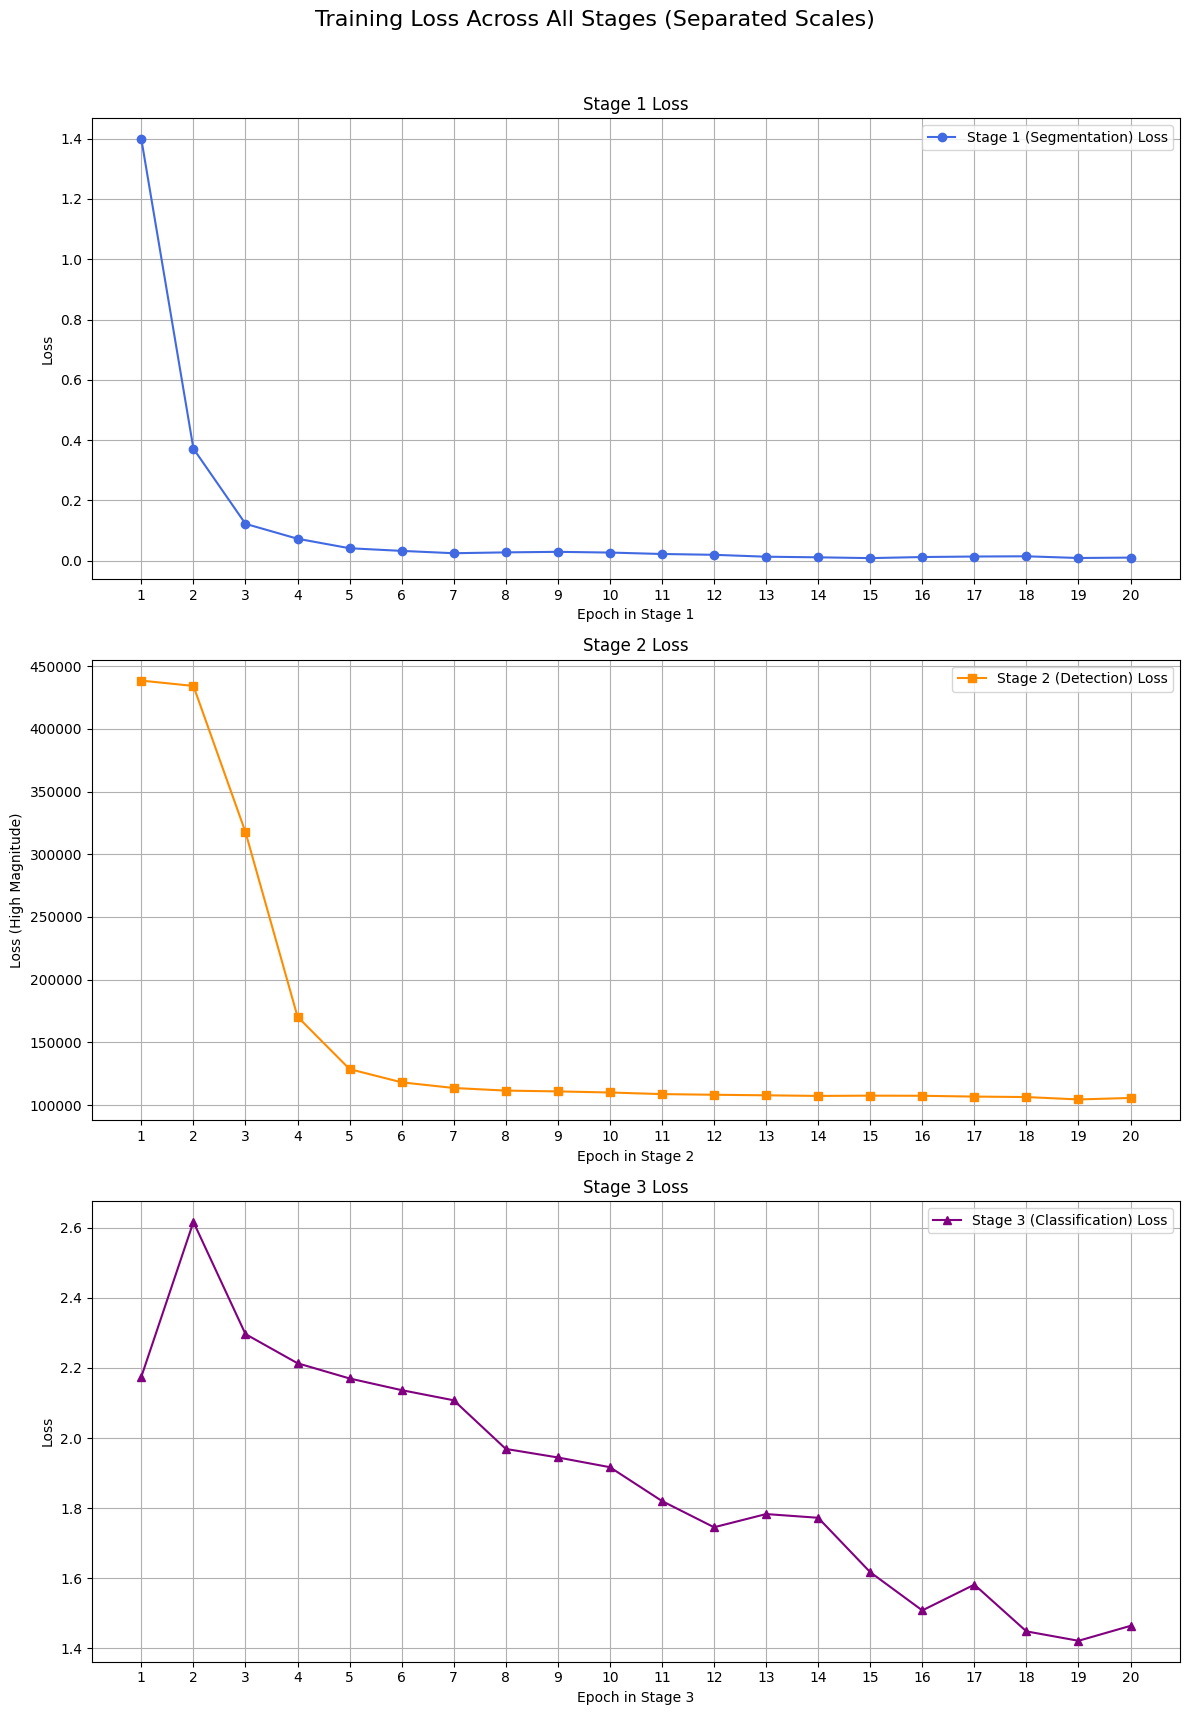

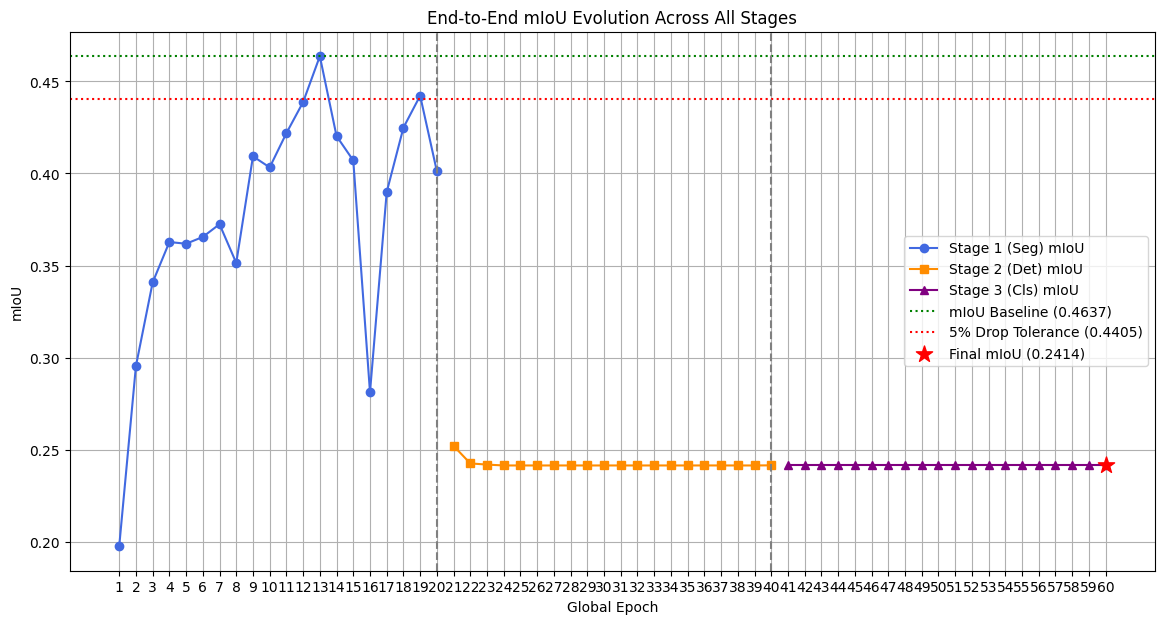

In [13]:
# ===============================================
# 📊 訓練過程視覺化分析 (優化版)
# ===============================================
import matplotlib.pyplot as plt

# --- 1. Loss 變化分析圖 (拆分為三個子圖) ---
# 建立一個包含 3 個子圖的 Figure，排列為 3 行 1 列
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Training Loss Across All Stages (Separated Scales)', fontsize=16)

# 子圖 1: Stage 1 (Segmentation)
axes[0].plot(range(1, stage1_len + 1), loss1_hist, 'o-', color='royalblue', label='Stage 1 (Segmentation) Loss')
axes[0].set_title('Stage 1 Loss')
axes[0].set_xlabel('Epoch in Stage 1')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(ticks=range(1, stage1_len + 1))

# 子圖 2: Stage 2 (Detection)
axes[1].plot(range(1, stage2_len + 1), loss2_hist, 's-', color='darkorange', label='Stage 2 (Detection) Loss')
axes[1].set_title('Stage 2 Loss')
axes[1].set_xlabel('Epoch in Stage 2')
axes[1].set_ylabel('Loss (High Magnitude)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(ticks=range(1, stage2_len + 1))


# 子圖 3: Stage 3 (Classification)
axes[2].plot(range(1, stage3_len + 1), loss3_hist, '^-', color='purple', label='Stage 3 (Classification) Loss')
axes[2].set_title('Stage 3 Loss')
axes[2].set_xlabel('Epoch in Stage 3')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(ticks=range(1, stage3_len + 1))

# 自動調整子圖間距，避免標籤重疊
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- 2. mIoU 完整演化趨勢圖 (保持不變) ---
plt.figure(figsize=(14, 7))

# 繪製三個階段的 mIoU 演化曲線
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# 標示基準線和 5% 下降的容忍線
mIoU_final = miou3_hist[-1] if miou3_hist else (miou2_hist[-1] if miou2_hist else miou1_hist[-1])
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# 繪製階段分隔線
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# 標示最終結果
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()

## 災難性遺忘處理( Replay buffer (≤ 10 images per task per step) )

In [14]:
### =================================================================
### 區塊一：模型、資料集與輔助工具 (完整版)
### =================================================================
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import average_precision_score

# ----------- 1. 統一模型定義 -----------
class UnifiedModel(nn.Module):
    def __init__(self, num_classes_cls=10, num_classes_det=10, num_classes_seg=21):
        super(UnifiedModel, self).__init__()
        # 🔗 Backbone: MobileNetV3 Small
        backbone = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.backbone = backbone.features

        # 🔗 FPN Neck
        # ✅ 修正：使用 MobileNetV3-Small features[3, 6, 12] 層的正確輸出通道 [24, 40, 576]
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[24, 40, 576],
            out_channels=128,
            extra_blocks=LastLevelMaxPool()
        )

        # 🧠 Shared conv head
        self.shared_head = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # 🎯 Output heads
        self.classifier = nn.Linear(128, num_classes_cls)
        self.det_head = nn.Conv2d(128, 5, 1)
        self.seg_head = nn.Conv2d(128, num_classes_seg, 1)

    def forward(self, x):
        feats = {}
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i in [3, 6, 12]:
                 feats[f'feat{i}'] = x

        fpn_feats = self.fpn(feats)
        fpn_out = fpn_feats['feat3']

        shared = self.shared_head(fpn_out)
        B, C, H, W = shared.shape

        cls_logits = self.classifier(torch.mean(shared.view(B, C, -1), dim=2))

        det_raw = self.det_head(shared)
        # ✅ 修正：將 det_output 的形狀從 (B, H, W, 5) 整形為 (B, H*W, 5)
        # 這樣更容易索引和比較
        det_output = det_raw.permute(0, 2, 3, 1).contiguous().view(B, -1, 5)

        seg_mask = self.seg_head(shared)

        return cls_logits, det_output, seg_mask

# ----------- 2. 資料集定義 -----------
class VOCSegmentationDataset(Dataset):
    """PASCAL VOC 2012 分割資料集"""
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_paths = sorted([Path(image_dir) / f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_paths = [p.with_suffix('.png') for p in self.image_paths]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        mask = mask.squeeze(0).long()
        mask = mask.clone()
        mask[(mask > 20) & (mask != 255)] = 255
        return img, mask

class MiniCocoDetection(Dataset):
    """Mini COCO 物件偵測資料集"""
    def __init__(self, img_dir, ann_path, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        with open(ann_path) as f:
            coco_data = json.load(f)
        self.img_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
        self.annotations = {img['id']: [] for img in coco_data['images']}
        for ann in coco_data['annotations']:
            self.annotations[ann['image_id']].append(ann)
        self.ids = list(self.img_id_to_filename.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        file_name = self.img_id_to_filename[img_id]
        img_path = self.img_dir / file_name
        img = Image.open(img_path).convert("RGB")
        targets = []
        if img_id in self.annotations:
            for ann in self.annotations[img_id]:
                x, y, w, h = ann['bbox']
                targets.append([(x + w / 2), (y + h / 2), w, h, 1.0])
        targets = torch.tensor(targets, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, targets

def build_cls_dataset(root_dir, input_size=512):
    """建立分類任務的訓練與驗證資料集"""
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor()])
    train_set = ImageFolder(root=Path(root_dir) / "train", transform=transform)
    val_set = ImageFolder(root=Path(root_dir) / "val", transform=transform)
    return train_set, val_set

def detection_collate_fn(batch):
    """處理物件偵測中不同數量的標註"""
    images = torch.stack([item[0] for item in batch], 0)
    targets = [item[1] for item in batch]
    return images, targets

# ----------- 3. 評估與輔助函式 -----------
def compute_mIoU(preds, targets, num_classes=21):
    """計算 mIoU"""
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(1.0)
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_segmentation(model, val_loader, device="cuda"):
    """評估分割任務的 mIoU"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)
            target_size = masks.shape[-2:]
            seg_out_upsampled = F.interpolate(seg_out, size=target_size, mode='bilinear', align_corners=False)
            preds = torch.argmax(seg_out_upsampled, dim=1)
            all_preds.append(preds)
            all_targets.append(masks)
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    mIoU = compute_mIoU(all_preds, all_targets)
    return mIoU

def evaluate_classification(model, val_loader, device="cuda"):
    """評估分類任務的 mAP 和 Top-1 Accuracy (修正版)"""
    model.eval()
    all_logits, all_labels = [], []
    num_classes = model.classifier.out_features

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            # 因為 labels 不需要參與模型運算，所以可以直接移至 CPU
            labels = labels.cpu()

            logits, _, _ = model(imgs)

            all_logits.append(logits.cpu())
            all_labels.append(labels) # ✅ 修正：現在收集的 labels 保證在 CPU 上

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    probs = F.softmax(logits, dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    top1 = (preds == labels.numpy()).mean()

    try:
        y_true_one_hot = np.eye(num_classes)[labels.numpy()]
        mAP = average_precision_score(y_true_one_hot, probs, average='macro')
    except Exception as e:
        print(f"Could not compute mAP: {e}")
        mAP = 0.0

    return mAP, top1

def print_grad_status(model):
    """印出模型主要部分的梯度狀態"""
    print("--- 模型梯度狀態檢查 ---")
    for name, param in model.named_parameters():
        if '.' in name:
            module_name = name.split('.')[0]
            if module_name in ['backbone', 'fpn', 'shared_head', 'classifier', 'det_head', 'seg_head']:
                 print(f"{module_name.ljust(15)} requires_grad: {param.requires_grad}")
                 break # 只印出每個模組的第一個參數狀態即可
    print("--------------------------")

In [15]:
### =================================================================
### 區塊二：具備「經驗回放」的訓練引擎 (完整版)
### =================================================================

def train_stage1_segmentation(model, train_loader, val_loader, epochs, lr, device):
    """Stage 1: Segmentation 訓練引擎 (修正版)"""
    print(f"🎯 Stage 1: Segmentation 訓練中，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    loss_history, miou_history = [], []
    best_mIoU = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, masks in progress_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            _, _, seg_out = model(imgs)

            # ✅ 修正：在計算 Loss 前，將高解析度的 mask 降採樣以匹配 seg_out 的大小
            target_size = seg_out.shape[-2:] # 獲取模型輸出的 H, W，例如 (64, 64)

            # interpolate 需要 4D 輸入 (N, C, H, W)，所以先 unsqueeze(1) 增加通道維度
            # 並轉為 float，降採樣後再 squeeze(1) 移除通道維度並轉回 long
            masks_downsampled = F.interpolate(
                masks.unsqueeze(1).float(),
                size=target_size,
                mode='nearest'
            ).squeeze(1).long()

            # 使用降採樣後的 mask 計算 Loss
            loss = criterion(seg_out, masks_downsampled)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        epoch_mIoU = evaluate_segmentation(model, val_loader, device)
        miou_history.append(epoch_mIoU)
        best_mIoU = max(best_mIoU, epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    print(f"\n✅ Stage 1 完成！記錄 mIoU_base = {best_mIoU:.4f}")
    return best_mIoU, loss_history, miou_history

def train_stage2_detection_with_replay(model, det_loader, seg_replay_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    """Stage 2: Detection 訓練引擎 (含 Segmentation 回放) (修正版)"""
    print(f"🔎 Stage 2: Detection 訓練中 (啟用 Replay)，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    det_loss_fn = torch.nn.MSELoss()
    seg_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history = [], []
    det_iter, replay_iter = iter(det_loader), iter(seg_replay_loader)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(range(len(det_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try:
                imgs_det, targets_det = next(det_iter)
            except StopIteration:
                det_iter = iter(det_loader); imgs_det, targets_det = next(det_iter)
            try:
                imgs_seg, masks_seg = next(replay_iter)
            except StopIteration:
                replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)

            main_bs = imgs_det.shape[0]
            all_imgs = torch.cat([imgs_det, imgs_seg], dim=0).to(device)
            targets_det = [t.to(device) for t in targets_det]
            masks_seg = masks_seg.to(device)
            optimizer.zero_grad()
            _, det_out, seg_out = model(all_imgs)

            loss_det, total_loss = 0, 0
            det_preds = det_out[:main_bs]
            for i in range(main_bs):
                if targets_det[i].shape[0] > 0:
                    loss_det += det_loss_fn(det_preds[i, :targets_det[i].shape[0], :], targets_det[i])

            # ✅ 修正：在計算 Replay Loss 前，將高解析度的 mask 降採樣
            seg_preds = seg_out[main_bs:]
            target_size = seg_preds.shape[-2:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)

            if isinstance(loss_det, torch.Tensor): total_loss += loss_det
            total_loss += replay_weight * loss_seg_replay

            if isinstance(total_loss, torch.Tensor):
                total_loss.backward(); optimizer.step()
                running_loss += total_loss.item()

        epoch_loss = running_loss / len(det_loader) if len(det_loader) > 0 else 0
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    print(f"📉 Stage 2 最終 mIoU drop: {mIoU_drop:.4f}")
    return mIoU_drop, loss_history, miou_history
def train_stage3_classification_with_replay(model, cls_loader, seg_replay_loader, cls_val_loader, seg_val_loader, mIoU_base, epochs, lr, replay_weight, device):
    """Stage 3: Classification 訓練引擎 (含 Segmentation 回放) (修正版)"""
    print(f"📘 Stage 3: Classification 訓練中 (啟用 Replay)，共 {epochs} 個 Epochs")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    cls_loss_fn = torch.nn.CrossEntropyLoss()
    seg_loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)
    loss_history, miou_history = [], []
    cls_iter, replay_iter = iter(cls_loader), iter(seg_replay_loader)

    mAP_base, Top1_base = evaluate_classification(model, cls_val_loader, device)
    print(f"Initial Classification Performance: mAP={mAP_base:.4f}, Top-1={Top1_base:.4f}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        progress_bar = tqdm(range(len(cls_loader)), desc=f"Epoch {epoch+1}/{epochs}")
        for step in progress_bar:
            try:
                imgs_cls, labels_cls = next(cls_iter)
            except StopIteration:
                cls_iter = iter(cls_loader); imgs_cls, labels_cls = next(cls_iter)
            try:
                imgs_seg, masks_seg = next(replay_iter)
            except StopIteration:
                replay_iter = iter(seg_replay_loader); imgs_seg, masks_seg = next(replay_iter)

            main_bs = imgs_cls.shape[0]
            all_imgs = torch.cat([imgs_cls, imgs_seg], dim=0).to(device)
            labels_cls, masks_seg = labels_cls.to(device), masks_seg.to(device)
            optimizer.zero_grad()
            cls_logits, _, seg_out = model(all_imgs)

            loss_cls = cls_loss_fn(cls_logits[:main_bs], labels_cls)

            # ✅ 修正：在計算 Replay Loss 前，將高解析度的 mask 降採樣
            seg_preds = seg_out[main_bs:]
            target_size = seg_preds.shape[-2:]
            masks_seg_downsampled = F.interpolate(masks_seg.unsqueeze(1).float(), size=target_size, mode='nearest').squeeze(1).long()
            loss_seg_replay = seg_loss_fn(seg_preds, masks_seg_downsampled)

            total_loss = loss_cls + replay_weight * loss_seg_replay

            total_loss.backward(); optimizer.step()
            running_loss += total_loss.item()

        # ... (後續的 loss 和 mIoU 記錄、評估部分不變) ...

        epoch_loss = running_loss / len(cls_loader)
        loss_history.append(epoch_loss)
        print(f"🔧 Epoch {epoch+1} Loss: {epoch_loss:.4f}")
        epoch_mIoU = evaluate_segmentation(model, seg_val_loader, device)
        miou_history.append(epoch_mIoU)
        print(f"📊 mIoU: {epoch_mIoU:.4f}")

    final_mIoU = miou_history[-1] if miou_history else mIoU_base
    mIoU_drop = max(0, mIoU_base - final_mIoU)
    mAP_now, top1_now = evaluate_classification(model, cls_val_loader, device)
    mAP_drop = max(0, mAP_base - mAP_now)
    top1_drop = max(0, Top1_base - top1_now)

    print(f"📉 mIoU_drop: {mIoU_drop:.4f}, mAP_drop: {mAP_drop:.4f}, Top1_drop: {top1_drop:.4f}")
    return mIoU_drop, mAP_drop, top1_drop, loss_history, miou_history

In [16]:
### =================================================================
### 區塊三：使用「經驗回放」的主執行流程
### =================================================================

# 1. CONFIGURATION BLOCK
CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "input_size": 512,
    "main_batch_size": 6,          # 主要任務的 batch size
    "replay_batch_size": 4,        # 回放任務的 batch size (6+4=10 <= 10)
    "replay_loss_weight": 0.8,     # 回放 loss 的權重，可調整
    "epochs": {"stage1": 20, "stage2": 20, "stage3": 20},
    "learning_rates": {"stage1": 1e-3, "stage2": 1e-4, "stage3": 1e-4},
    "data_paths": {
        "seg_train": "data/mini_voc_seg/train",
        "seg_val": "data/mini_voc_seg/val",
        "det_train": "data/mini_coco_det/train",
        "det_ann_train": "data/mini_coco_det/annotations/mini_instances_train2017.json",
        "cls_root": "data/imagenette_160",
    }
}

# 2. DATA PREPARATION
def prepare_dataloaders_for_replay(config):
    """建立所有任務所需，包含回放的 DataLoaders"""
    print("--- 正在準備所有 DataLoaders (含 Replay)... ---")
    img_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"])), transforms.ToTensor()])
    mask_tf = transforms.Compose([transforms.Resize((config["input_size"], config["input_size"]), interpolation=Image.NEAREST), transforms.PILToTensor()])

    seg_train_ds = VOCSegmentationDataset(config["data_paths"]["seg_train"], img_tf, mask_tf)
    seg_val_ds = VOCSegmentationDataset(config["data_paths"]["seg_val"], img_tf, mask_tf)
    det_train_ds = MiniCocoDetection(config["data_paths"]["det_train"], config["data_paths"]["det_ann_train"], img_tf)
    cls_train_ds, cls_val_ds = build_cls_dataset(config["data_paths"]["cls_root"])

    loaders = {
        "seg_train": DataLoader(seg_train_ds, batch_size=config["main_batch_size"], shuffle=True),
        "seg_val": DataLoader(seg_val_ds, batch_size=1),
        "seg_replay": DataLoader(seg_train_ds, batch_size=config["replay_batch_size"], shuffle=True, drop_last=True),
        "det_train": DataLoader(det_train_ds, batch_size=config["main_batch_size"], shuffle=True, collate_fn=detection_collate_fn),
        "cls_train": DataLoader(cls_train_ds, batch_size=config["main_batch_size"], shuffle=True),
        "cls_val": DataLoader(cls_val_ds, batch_size=config["main_batch_size"])
    }
    print("✅ 所有 DataLoaders 準備完成！")
    return loaders

# 3. MAIN EXECUTION
model = UnifiedModel().to(CONFIG["device"])
dataloaders = prepare_dataloaders_for_replay(CONFIG)

# Stage 1
mIoU_base, loss1_hist, miou1_hist = train_stage1_segmentation(
    model, dataloaders["seg_train"], dataloaders["seg_val"],
    epochs=CONFIG["epochs"]["stage1"], lr=CONFIG["learning_rates"]["stage1"], device=CONFIG["device"]
)

# Stage 2
print_grad_status(model)
mIoU_drop2, loss2_hist, miou2_hist = train_stage2_detection_with_replay(
    model, dataloaders["det_train"], dataloaders["seg_replay"], dataloaders["seg_val"],
    mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage2"],
    lr=CONFIG["learning_rates"]["stage2"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
)

# Stage 3
print_grad_status(model)
mIoU_drop3, mAP_drop3, Top1_drop3, loss3_hist, miou3_hist = train_stage3_classification_with_replay(
    model, dataloaders["cls_train"], dataloaders["seg_replay"], dataloaders["cls_val"], dataloaders["seg_val"],
    mIoU_base=mIoU_base, epochs=CONFIG["epochs"]["stage3"],
    lr=CONFIG["learning_rates"]["stage3"], replay_weight=CONFIG["replay_loss_weight"], device=CONFIG["device"]
)

# --- 彙總數據以供繪圖 ---
all_losses = loss1_hist + loss2_hist + loss3_hist
all_mious = miou1_hist + miou2_hist + miou3_hist
stage1_len, stage2_len, stage3_len = len(loss1_hist), len(loss2_hist), len(loss3_hist)

print("\n--- 訓練流程已全部完成，可以執行視覺化分析 Cell。---")

--- 正在準備所有 DataLoaders (含 Replay)... ---
✅ 所有 DataLoaders 準備完成！
🎯 Stage 1: Segmentation 訓練中，共 20 個 Epochs


Epoch 1/20: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s]


🔧 Epoch 1 Loss: 1.3278
📊 mIoU: 0.8448


Epoch 2/20: 100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


🔧 Epoch 2 Loss: 0.3735
📊 mIoU: 0.8979


Epoch 3/20: 100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


🔧 Epoch 3 Loss: 0.1057
📊 mIoU: 0.8984


Epoch 4/20: 100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


🔧 Epoch 4 Loss: 0.0760
📊 mIoU: 0.8988


Epoch 5/20: 100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


🔧 Epoch 5 Loss: 0.0633
📊 mIoU: 0.9044


Epoch 6/20: 100%|██████████| 40/40 [00:05<00:00,  7.46it/s]


🔧 Epoch 6 Loss: 0.0454
📊 mIoU: 0.9067


Epoch 7/20: 100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


🔧 Epoch 7 Loss: 0.0318
📊 mIoU: 0.9084


Epoch 8/20: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


🔧 Epoch 8 Loss: 0.0423
📊 mIoU: 0.9080


Epoch 9/20: 100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


🔧 Epoch 9 Loss: 0.0251
📊 mIoU: 0.9123


Epoch 10/20: 100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


🔧 Epoch 10 Loss: 0.0249
📊 mIoU: 0.9178


Epoch 11/20: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


🔧 Epoch 11 Loss: 0.0185
📊 mIoU: 0.9053


Epoch 12/20: 100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


🔧 Epoch 12 Loss: 0.0251
📊 mIoU: 0.9098


Epoch 13/20: 100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


🔧 Epoch 13 Loss: 0.0231
📊 mIoU: 0.9059


Epoch 14/20: 100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


🔧 Epoch 14 Loss: 0.0285
📊 mIoU: 0.9064


Epoch 15/20: 100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


🔧 Epoch 15 Loss: 0.0329
📊 mIoU: 0.9016


Epoch 16/20: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


🔧 Epoch 16 Loss: 0.0374
📊 mIoU: 0.9136


Epoch 17/20: 100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


🔧 Epoch 17 Loss: 0.0189
📊 mIoU: 0.9056


Epoch 18/20: 100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


🔧 Epoch 18 Loss: 0.0159
📊 mIoU: 0.9078


Epoch 19/20: 100%|██████████| 40/40 [00:08<00:00,  4.91it/s]


🔧 Epoch 19 Loss: 0.0257
📊 mIoU: 0.9070


Epoch 20/20: 100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


🔧 Epoch 20 Loss: 0.0424
📊 mIoU: 0.9068

✅ Stage 1 完成！記錄 mIoU_base = 0.9178
--- 模型梯度狀態檢查 ---
backbone        requires_grad: True
--------------------------
🔎 Stage 2: Detection 訓練中 (啟用 Replay)，共 20 個 Epochs


Epoch 1/20: 100%|██████████| 40/40 [00:08<00:00,  4.84it/s]


🔧 Epoch 1 Loss: 329066.5266
📊 mIoU: 0.9042


Epoch 2/20: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]


🔧 Epoch 2 Loss: 325739.9113
📊 mIoU: 0.8978


Epoch 3/20: 100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


🔧 Epoch 3 Loss: 309704.3809
📊 mIoU: 0.8916


Epoch 4/20: 100%|██████████| 40/40 [00:07<00:00,  5.13it/s]


🔧 Epoch 4 Loss: 248110.0184
📊 mIoU: 0.8916


Epoch 5/20: 100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


🔧 Epoch 5 Loss: 197287.6840
📊 mIoU: 0.8916


Epoch 6/20: 100%|██████████| 40/40 [00:08<00:00,  4.83it/s]


🔧 Epoch 6 Loss: 167691.6475
📊 mIoU: 0.8916


Epoch 7/20: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


🔧 Epoch 7 Loss: 150316.3748
📊 mIoU: 0.8916


Epoch 8/20: 100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


🔧 Epoch 8 Loss: 139184.6570
📊 mIoU: 0.8916


Epoch 9/20: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s]


🔧 Epoch 9 Loss: 130341.5051
📊 mIoU: 0.8916


Epoch 10/20: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s]


🔧 Epoch 10 Loss: 123184.0445
📊 mIoU: 0.8916


Epoch 11/20: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]


🔧 Epoch 11 Loss: 116122.1885
📊 mIoU: 0.8916


Epoch 12/20: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


🔧 Epoch 12 Loss: 111398.1667
📊 mIoU: 0.8916


Epoch 13/20: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s]


🔧 Epoch 13 Loss: 106809.9090
📊 mIoU: 0.8916


Epoch 14/20: 100%|██████████| 40/40 [00:07<00:00,  5.14it/s]


🔧 Epoch 14 Loss: 102812.0828
📊 mIoU: 0.8916


Epoch 15/20: 100%|██████████| 40/40 [00:08<00:00,  4.90it/s]


🔧 Epoch 15 Loss: 99258.1723
📊 mIoU: 0.8916


Epoch 16/20: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s]


🔧 Epoch 16 Loss: 96530.8371
📊 mIoU: 0.8916


Epoch 17/20: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s]


🔧 Epoch 17 Loss: 94588.4944
📊 mIoU: 0.8916


Epoch 18/20: 100%|██████████| 40/40 [00:07<00:00,  5.13it/s]


🔧 Epoch 18 Loss: 92268.7827
📊 mIoU: 0.8916


Epoch 19/20: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]


🔧 Epoch 19 Loss: 89833.7269
📊 mIoU: 0.8916


Epoch 20/20: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


🔧 Epoch 20 Loss: 87790.3023
📊 mIoU: 0.8916
📉 Stage 2 最終 mIoU drop: 0.0262
--- 模型梯度狀態檢查 ---
backbone        requires_grad: True
--------------------------
📘 Stage 3: Classification 訓練中 (啟用 Replay)，共 20 個 Epochs
Initial Classification Performance: mAP=0.2135, Top-1=0.0833


Epoch 1/20: 100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


🔧 Epoch 1 Loss: 2.3773
📊 mIoU: 0.8924


Epoch 2/20: 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]


🔧 Epoch 2 Loss: 2.2843
📊 mIoU: 0.9020


Epoch 3/20: 100%|██████████| 40/40 [00:06<00:00,  6.00it/s]


🔧 Epoch 3 Loss: 2.1819
📊 mIoU: 0.9032


Epoch 4/20: 100%|██████████| 40/40 [00:06<00:00,  6.32it/s]


🔧 Epoch 4 Loss: 2.0711
📊 mIoU: 0.9038


Epoch 5/20: 100%|██████████| 40/40 [00:06<00:00,  6.02it/s]


🔧 Epoch 5 Loss: 1.9273
📊 mIoU: 0.9010


Epoch 6/20: 100%|██████████| 40/40 [00:06<00:00,  5.90it/s]


🔧 Epoch 6 Loss: 1.8007
📊 mIoU: 0.9030


Epoch 7/20: 100%|██████████| 40/40 [00:06<00:00,  5.96it/s]


🔧 Epoch 7 Loss: 1.6271
📊 mIoU: 0.9018


Epoch 8/20: 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]


🔧 Epoch 8 Loss: 1.4767
📊 mIoU: 0.9012


Epoch 9/20: 100%|██████████| 40/40 [00:06<00:00,  5.97it/s]


🔧 Epoch 9 Loss: 1.3670
📊 mIoU: 0.9038


Epoch 10/20: 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]


🔧 Epoch 10 Loss: 1.2430
📊 mIoU: 0.9016


Epoch 11/20: 100%|██████████| 40/40 [00:06<00:00,  5.92it/s]


🔧 Epoch 11 Loss: 1.1607
📊 mIoU: 0.9005


Epoch 12/20: 100%|██████████| 40/40 [00:06<00:00,  6.28it/s]


🔧 Epoch 12 Loss: 1.0514
📊 mIoU: 0.9032


Epoch 13/20: 100%|██████████| 40/40 [00:06<00:00,  5.99it/s]


🔧 Epoch 13 Loss: 1.0266
📊 mIoU: 0.9011


Epoch 14/20: 100%|██████████| 40/40 [00:06<00:00,  5.76it/s]


🔧 Epoch 14 Loss: 0.9239
📊 mIoU: 0.9010


Epoch 15/20: 100%|██████████| 40/40 [00:06<00:00,  5.92it/s]


🔧 Epoch 15 Loss: 0.8824
📊 mIoU: 0.9103


Epoch 16/20: 100%|██████████| 40/40 [00:06<00:00,  6.25it/s]


🔧 Epoch 16 Loss: 0.8348
📊 mIoU: 0.9116


Epoch 17/20: 100%|██████████| 40/40 [00:06<00:00,  6.03it/s]


🔧 Epoch 17 Loss: 0.7029
📊 mIoU: 0.9068


Epoch 18/20: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


🔧 Epoch 18 Loss: 0.6869
📊 mIoU: 0.9125


Epoch 19/20: 100%|██████████| 40/40 [00:06<00:00,  5.82it/s]


🔧 Epoch 19 Loss: 0.6576
📊 mIoU: 0.9111


Epoch 20/20: 100%|██████████| 40/40 [00:06<00:00,  6.24it/s]


🔧 Epoch 20 Loss: 0.4892
📊 mIoU: 0.9135
📉 mIoU_drop: 0.0044, mAP_drop: 0.0000, Top1_drop: 0.0000

--- 訓練流程已全部完成，可以執行視覺化分析 Cell。---


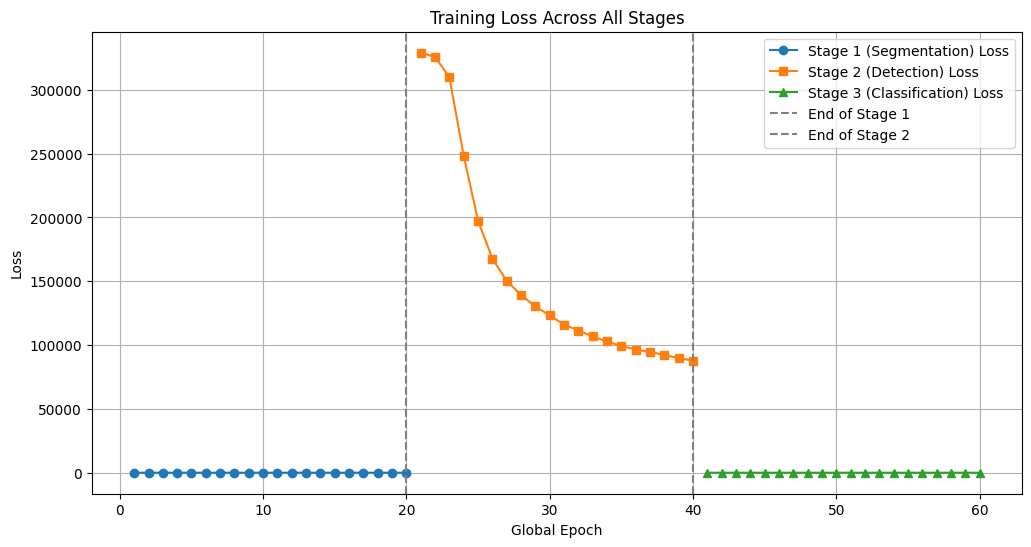

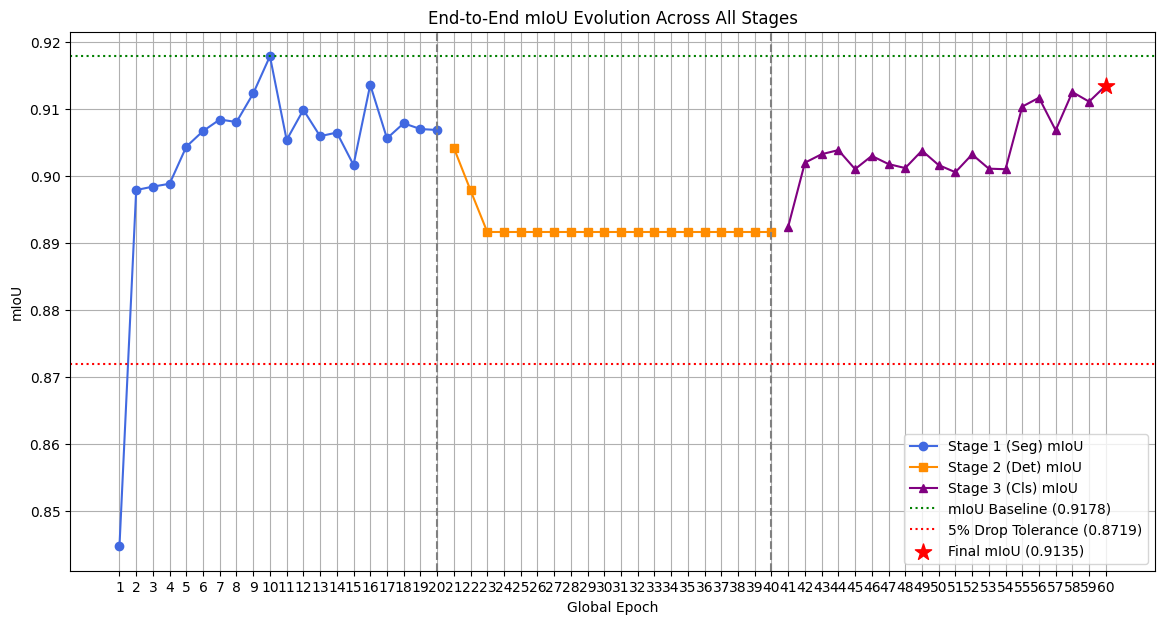

In [17]:
# ===============================================
# 📊 訓練過程視覺化分析
# ===============================================
import matplotlib.pyplot as plt
# 1. Loss 變化分析圖
plt.figure(figsize=(12, 6))
plt.plot(range(1, stage1_len + 1), loss1_hist, 'o-', label='Stage 1 (Segmentation) Loss')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), loss2_hist, 's-', label='Stage 2 (Detection) Loss')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), loss3_hist, '^-', label='Stage 3 (Classification) Loss')

# 繪製階段分隔線
plt.axvline(x=stage1_len, color='grey', linestyle='--', label='End of Stage 1')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--', label='End of Stage 2')

plt.title('Training Loss Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. mIoU 完整演化趨勢圖
plt.figure(figsize=(14, 7))

# 繪製三個階段的 mIoU 演化曲線
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# 標示基準線和 5% 下降的容忍線
mIoU_final = miou3_hist[-1]
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# 繪製階段分隔線
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# 標示最終結果
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()

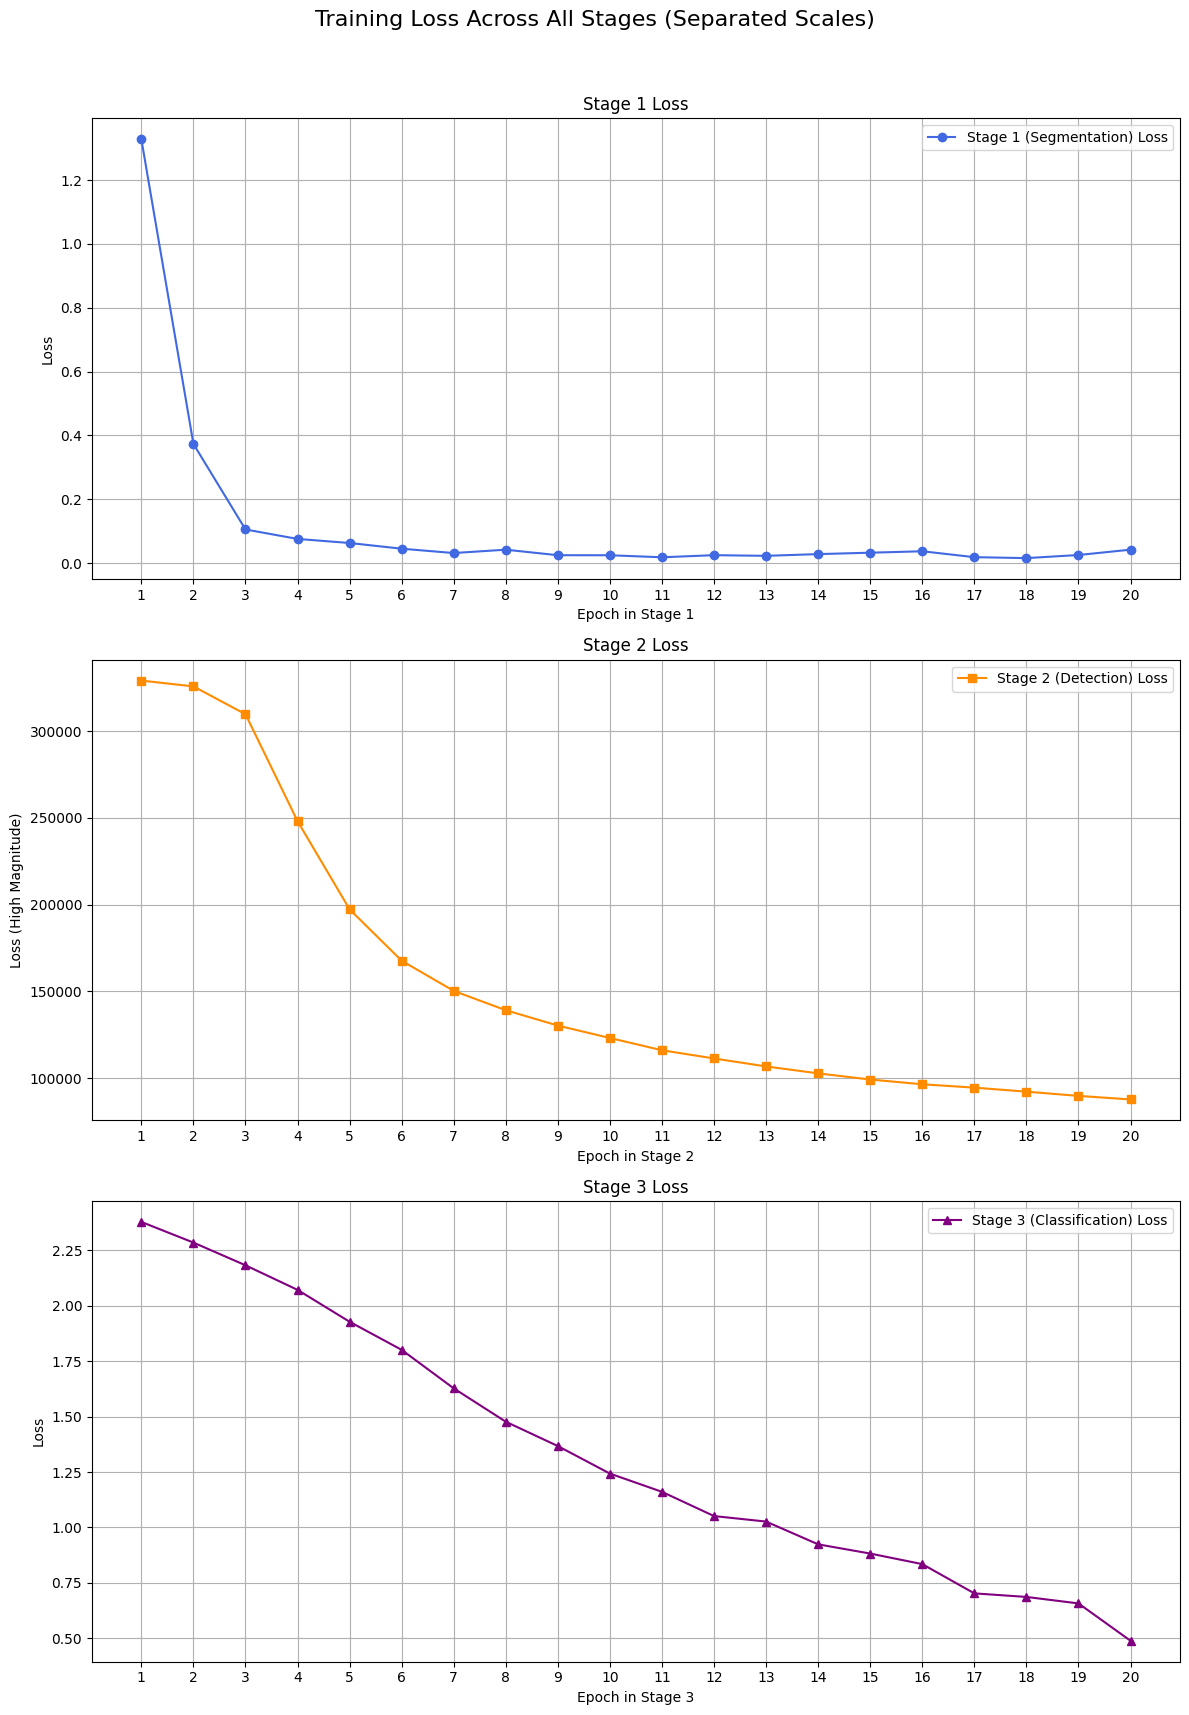

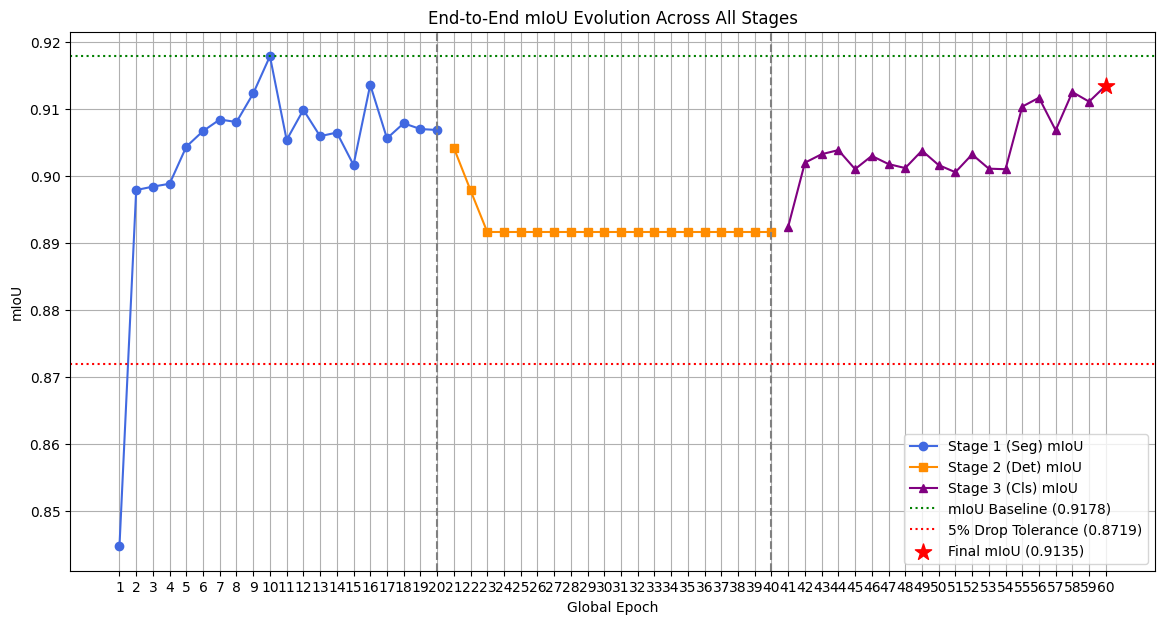

In [18]:
# ===============================================
# 📊 訓練過程視覺化分析 (優化版)
# ===============================================
import matplotlib.pyplot as plt

# --- 1. Loss 變化分析圖 (拆分為三個子圖) ---
# 建立一個包含 3 個子圖的 Figure，排列為 3 行 1 列
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Training Loss Across All Stages (Separated Scales)', fontsize=16)

# 子圖 1: Stage 1 (Segmentation)
axes[0].plot(range(1, stage1_len + 1), loss1_hist, 'o-', color='royalblue', label='Stage 1 (Segmentation) Loss')
axes[0].set_title('Stage 1 Loss')
axes[0].set_xlabel('Epoch in Stage 1')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(ticks=range(1, stage1_len + 1))

# 子圖 2: Stage 2 (Detection)
axes[1].plot(range(1, stage2_len + 1), loss2_hist, 's-', color='darkorange', label='Stage 2 (Detection) Loss')
axes[1].set_title('Stage 2 Loss')
axes[1].set_xlabel('Epoch in Stage 2')
axes[1].set_ylabel('Loss (High Magnitude)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(ticks=range(1, stage2_len + 1))


# 子圖 3: Stage 3 (Classification)
axes[2].plot(range(1, stage3_len + 1), loss3_hist, '^-', color='purple', label='Stage 3 (Classification) Loss')
axes[2].set_title('Stage 3 Loss')
axes[2].set_xlabel('Epoch in Stage 3')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(ticks=range(1, stage3_len + 1))

# 自動調整子圖間距，避免標籤重疊
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# --- 2. mIoU 完整演化趨勢圖 (保持不變) ---
plt.figure(figsize=(14, 7))

# 繪製三個階段的 mIoU 演化曲線
plt.plot(range(1, stage1_len + 1), miou1_hist, 'o-', color='royalblue', label='Stage 1 (Seg) mIoU')
plt.plot(range(stage1_len + 1, stage1_len + stage2_len + 1), miou2_hist, 's-', color='darkorange', label='Stage 2 (Det) mIoU')
plt.plot(range(stage1_len + stage2_len + 1, stage1_len + stage2_len + stage3_len + 1), miou3_hist, '^-', color='purple', label='Stage 3 (Cls) mIoU')

# 標示基準線和 5% 下降的容忍線
mIoU_final = miou3_hist[-1] if miou3_hist else (miou2_hist[-1] if miou2_hist else miou1_hist[-1])
plt.axhline(y=mIoU_base, color='green', linestyle=':', label=f'mIoU Baseline ({mIoU_base:.4f})')
plt.axhline(y=mIoU_base * 0.95, color='red', linestyle=':', label=f'5% Drop Tolerance ({mIoU_base*0.95:.4f})')

# 繪製階段分隔線
plt.axvline(x=stage1_len, color='grey', linestyle='--')
plt.axvline(x=stage1_len + stage2_len, color='grey', linestyle='--')

# 標示最終結果
plt.scatter(len(all_mious), mIoU_final, s=150, c='red', marker='*', zorder=5, label=f'Final mIoU ({mIoU_final:.4f})')

plt.title('End-to-End mIoU Evolution Across All Stages')
plt.xlabel('Global Epoch')
plt.ylabel('mIoU')
plt.xticks(ticks=range(1, len(all_mious) + 1))
plt.legend()
plt.grid(True)
plt.show()